In [25]:
from tenLoader import TenVideoDataset, normalize, TenVideoTest, TenVideoInfer
from model import IterWholeFirst
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import PIL.Image as Image
import numpy as np
from preprocess_utensils import get_gray_image, get_boundary_iou
import json
from loss import order_loss, chamer_distance_loss
import random
import time

In [2]:
dataset = TenVideoDataset()
data_loader = DataLoader(dataset, batch_size=1, shuffle=True)
testset = TenVideoTest()

In [3]:
video_idx, pre_idx, fir_img, pre_img, cur_img, fir_bou, pre_bou, cur_bou = next(iter(data_loader))
pre_idx

tensor([2])

Text(0.5, 1.0, 'First Frame in test set')

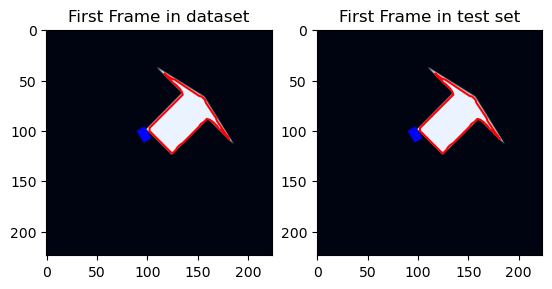

In [4]:
index = 0
plt.subplot(1, 2, 1)
plt.imshow(normalize(fir_img[index].permute(1, 2, 0)))
plt.plot(fir_bou[index][:, 0], fir_bou[index][:, 1], 'r')
plt.title("First Frame in dataset")
plt.subplot(1, 2, 2)
plt.imshow(normalize(testset.get_item(video_idx.item(), 0)[0].permute(1, 2, 0)))
plt.plot(fir_bou[index][:, 0], fir_bou[index][:, 1], 'r')
plt.title("First Frame in test set")

Text(0.5, 1.0, 'Current Frame in test set')

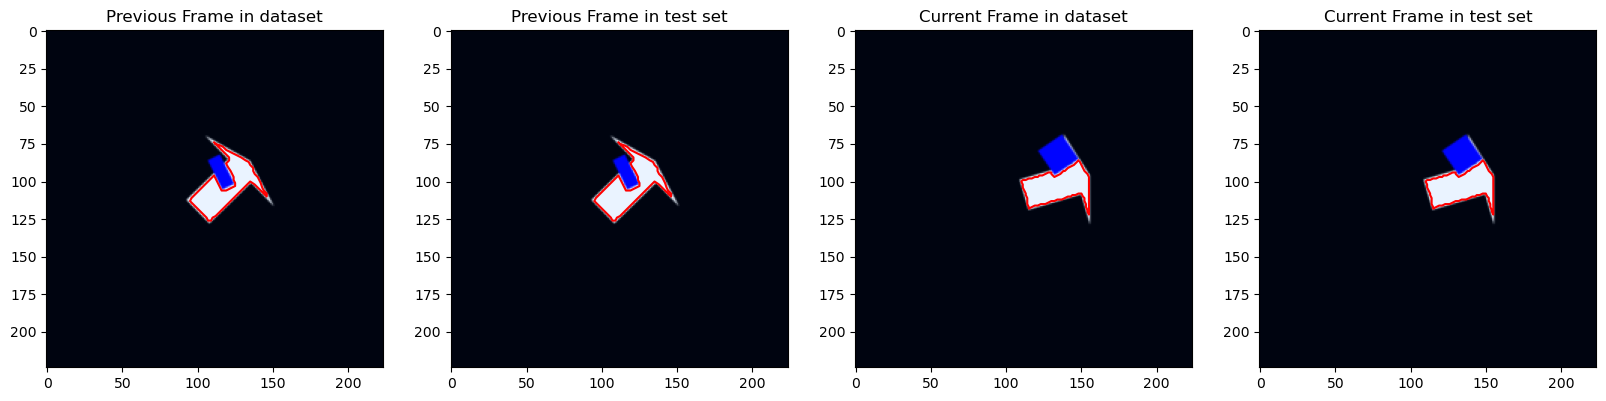

In [5]:
index = 0
plt.figure(figsize=(20, 5))
plt.subplot(1, 4, 1)
plt.imshow(normalize(pre_img[index].permute(1, 2, 0)))
plt.plot(pre_bou[index][:, 0], pre_bou[index][:, 1], 'r')
plt.title("Previous Frame in dataset")
plt.subplot(1, 4, 2)
plt.imshow(normalize(testset.get_item(video_idx.item(), pre_idx.item())[0].permute(1, 2, 0)))
plt.plot(pre_bou[index][:, 0], pre_bou[index][:, 1], 'r')
plt.title("Previous Frame in test set")
plt.subplot(1, 4, 3)
plt.imshow(normalize(cur_img[index].permute(1, 2, 0)))
plt.plot(cur_bou[index][:, 0], cur_bou[index][:, 1], 'r')
plt.title("Current Frame in dataset")
plt.subplot(1, 4, 4)
plt.imshow(normalize(testset.get_item(video_idx.item(), pre_idx.item()+1)[0].permute(1, 2, 0)))
plt.plot(cur_bou[index][:, 0], cur_bou[index][:, 1], 'r')
plt.title("Current Frame in test set")

In [6]:
model = IterWholeFirst(add_xy_in_token=True, use_unet=True)

/work3/s232248/miniconda3/envs/vos/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [7]:
model = model.cuda()
results = model(
    fir_img.cuda(),
    fir_bou.cuda(),
    pre_img.cuda(),
    cur_img.cuda(),
    pre_bou.cuda(),
)

In [8]:
order_loss(results[-1], cur_bou.cuda())

tensor(24.6480, device='cuda:0', grad_fn=<DivBackward0>)

In [9]:
torch.cuda.memory_allocated() / 1024**3

1.8885498046875

In [10]:
testset = TenVideoTest()
model_infer = TenVideoInfer(testset)

In [11]:
model_infer.infer_model(model)

In [13]:
model_infer.get_total_iou()

0.1597495945364263

In [19]:
model_infer.show_infer_result(5, 0)

KeyError: 5

<Figure size 1500x2000 with 0 Axes>

In [31]:
model = IterWholeFirst(add_xy_in_token=True, use_unet=True).cuda()
testset = TenVideoTest()
model_infer = TenVideoInfer(testset)
dataset = TenVideoDataset()
data_loader = DataLoader(dataset, batch_size=1, shuffle=True)


In [30]:
dict_loss = {}
dict_iou = {}
interval_epochs = 30
interval_num = 5
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-3)
gradient_clip = 0
epoch_index = 0

In [32]:
print(f"Start training at {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime())}")
for interval in range(interval_num):
    for e in range(interval_epochs):
        model.train()
        mean_loss = 0
        for video_idx, pre_idx, fir_img, pre_img, cur_img, fir_bou, pre_bou, cur_bou in data_loader:
            pre_idx = pre_idx.item()
            video_idx = video_idx.item()
            pre_bou = model_infer.get_boundary(video_idx, pre_idx)
            pre_bou = pre_bou.unsqueeze(0).cuda()
            optimizer.zero_grad()
            results = model(
                fir_img.cuda(),
                fir_bou.cuda(),
                pre_img.cuda(),
                cur_img.cuda(),
                pre_bou.cuda(),
            )
            refine_num = len(results)
            loss = 0
            for i in range(refine_num):
                loss += 0.8 ** (refine_num - i - 1) * order_loss(results[i], cur_bou.cuda())
            loss.backward()
            if gradient_clip > 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clip)
            optimizer.step()
            mean_loss += loss.item()
        mean_loss /= len(data_loader)
        print(
            f"{time.strftime('%Y-%m-%d %H:%M:%S', time.localtime())}: Epoch {epoch_index}: Loss: {mean_loss:.4f}"
        )
        dict_loss[epoch_index] = mean_loss
        epoch_index += 1
    model_infer.infer_model(model)
    model_infer.show_infer_result(4, 0)
    print(
        f"{time.strftime('%Y-%m-%d %H:%M:%S', time.localtime())}: IoU in video 4:", model_infer.get_video_iou(4)
    )
    total_iou = model_infer.get_total_iou()
    dict_iou[epoch_index] = total_iou
    print(f"{time.strftime('%Y-%m-%d %H:%M:%S', time.localtime())}: Epoch {epoch_index}: Total IoU {total_iou:.4f}")
    if interval_epochs > 20:
        interval_epochs -= 10

Start training at 2024-04-11 18:13:06
2024-04-11 18:18:29: Epoch 0: Loss: 54.3787
2024-04-11 18:23:52: Epoch 1: Loss: 54.3807


KeyboardInterrupt: 